# Optimal Gridsearch
An Exploration of Bayesian approach to hyperparameter tuning.

In [1]:
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, DMatrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_evaluations
from skopt.space import Real, Categorical, Integer
from skopt.utils import point_asdict

## Import Data
We use the ILEC 2009-15 Individual Life Insurance Mortality Experience Report data (https://www.soa.org/resources/research-reports/2019/2009-2015-individual-life-mortality/). Cases are restricted between issue age [40,60) and duration < 10. Cases without exposure are omitted.

In [2]:
cols = [ 'Preferred Indicator',
         'Face Amount Band','Gender',
         'Smoker Status',
 'Insurance Plan',
 'Issue Age',
 'Duration',
 'Attained Age',
 'Number of Deaths',
 'Policies Exposed',]
# dat = pd.read_csv('../../scratchpad/2009-15 Data 20180601.txt',nrows=2e6,sep='\t',usecols=cols)
# dat = dat[(dat['Issue Age']>=40)&(dat['Issue Age'] <60)&(dat['Duration']<10)]
# dat = dat[dat['Policies Exposed']>0]

dat= pd.read_csv('../../scratchpad/ILECsample_40-60.txt')

In [3]:
dat.head()

,Unnamed: 0,Preferred Indicator,Gender,Smoker Status,Insurance Plan,Issue Age,Duration,Attained Age,Face Amount Band,Number of Deaths,Policies Exposed
0,0,1,Female,NonSmoker,Term,44,9,52,100000-249999,0,2.660124
1,1,1,Female,NonSmoker,ULSG,40,2,41,1000000-2499999,0,0.364384
2,2,1,Female,NonSmoker,Term,44,9,52,100000-249999,0,20.324095
3,3,1,Female,NonSmoker,ULSG,40,2,41,1000000-2499999,0,0.871233
4,4,1,Female,NonSmoker,ULSG,40,2,41,2500000-4999999,0,0.172603


In [4]:
regs = [ 'Preferred Indicator',
         'Face Amount Band','Gender',
         'Smoker Status',
 'Insurance Plan',
 'Issue Age',
 'Duration']

labelencoder = LabelEncoder()
dat['Face Amount Band'] = labelencoder.fit_transform(dat['Face Amount Band'].astype('category'))
dat['Gender'] = labelencoder.fit_transform(dat['Gender'].astype('category'))
dat['Smoker Status'] = labelencoder.fit_transform(dat['Smoker Status'].astype('category'))
dat['Insurance Plan'] = labelencoder.fit_transform(dat['Insurance Plan'].astype('category'))


X_train, X_eval, y_train, y_eval, exp_train, exp_eval = train_test_split(dat[regs],dat['Number of Deaths'], dat['Policies Exposed'],
                                                    test_size=.3, random_state=52,
                                                    stratify = dat[['Issue Age','Duration','Gender']])

## Create Callback Function
This function outputs the fit statistics for each test to .csv.

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
def cb(v,filename = '../Output/tuning_results.csv', verbose = 0):
    last_point = v.x_iters[-1]
    p = point_asdict(opt.search_spaces, last_point)
    if verbose>0:
        print("Tried {0}, score ={1}".format(p,opt.cv_results_.get('mean_test_score')[-1]))
    df_cv = pd.DataFrame(opt.cv_results_.get('params')).\
    assign(score = opt.cv_results_.get('mean_test_score'))
    df_cv = df_cv.assign(train_score = opt.cv_results_.get('mean_train_score'))
    df_cv['train_test_diff'] = df_cv.train_score-df_cv.score
    if verbose>0:
        print("best score = {0} @ diff = {1}".format(df_cv.score.max(),df_cv[df_cv.score==df_cv.score.max()].train_test_diff.min()))
    if filename:
        df_cv.to_csv(filename)

In [8]:
search_grid = {
        'model__objective':['count:poisson'],
        'model__n_estimators': Integer(10,1000),
        'model__gamma': (1e-8, 1e+3, 'log-uniform'),
        'model__max_depth': Integer(2, 8), 
        'model__learning_rate': Real(0.005,0.5), 
    }

fit_params = {
        'model__base_margin':np.log(exp_train)
    }

## Global Gridsearch
Here we use the default method that randomly draws acqusition funcitons. We perform 30 trials to estimate the global maxima.

In [9]:
my_cb = partial(cb,filename='../Output/tuning_results_global.csv',verbose = 1)

pipe = Pipeline(
    steps = [('model', XGBRegressor())],verbose = True
)

opt = BayesSearchCV(
    pipe,
    search_grid,
    fit_params = fit_params,
    optimizer_kwargs = {'random_state' : 55},
    n_iter=50,
    cv=3,
    return_train_score = True
)

opt.fit(X_train,y_train,callback = my_cb)

[Pipeline] ............. (step 1 of 1) Processing model, total=  10.0s
[Pipeline] ............. (step 1 of 1) Processing model, total=  10.1s
[Pipeline] ............. (step 1 of 1) Processing model, total=   9.9s
Tried OrderedDict([('model__gamma', 7.712664794512572), ('model__learning_rate', 0.03407495766124821), ('model__max_depth', 5), ('model__n_estimators', 930), ('model__objective', 'count:poisson')]), score =-0.007297951774882804
best score = -0.007297951774882804 @ diff = 9.224395097770597e-05
[Pipeline] ............. (step 1 of 1) Processing model, total=   8.7s
[Pipeline] ............. (step 1 of 1) Processing model, total=   8.9s
[Pipeline] ............. (step 1 of 1) Processing model, total=   8.8s
Tried OrderedDict([('model__gamma', 2.832714777417903e-08), ('model__learning_rate', 0.020619205362856434), ('model__max_depth', 5), ('model__n_estimators', 827), ('model__objective', 'count:poisson')]), score =-0.006748573455447248
best score = -0.006748573455447248 @ diff = 0.0

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                      

Best Iteration: 12   BestScore: -0.006189249852516642
Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0.000688263868558122,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.1383680930978989,
                              max_delta_step=0.699999988, max_depth=2,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=92,
                              n_jobs=36, num_parallel_tree=1,
                              objective='count:poisson', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                              subsample=1, tree_method='exact',
                              val

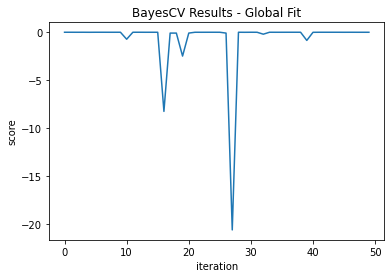

In [10]:
print("Best Iteration:",opt.best_index_,"  BestScore:" ,opt.best_score_)
print(opt.best_estimator_)
rslts = pd.DataFrame.from_dict(opt.cv_results_)
plt.plot(rslts.index,rslts['mean_test_score'])
plt.title('BayesCV Results - Global Fit')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

### Objective Dependence Plot

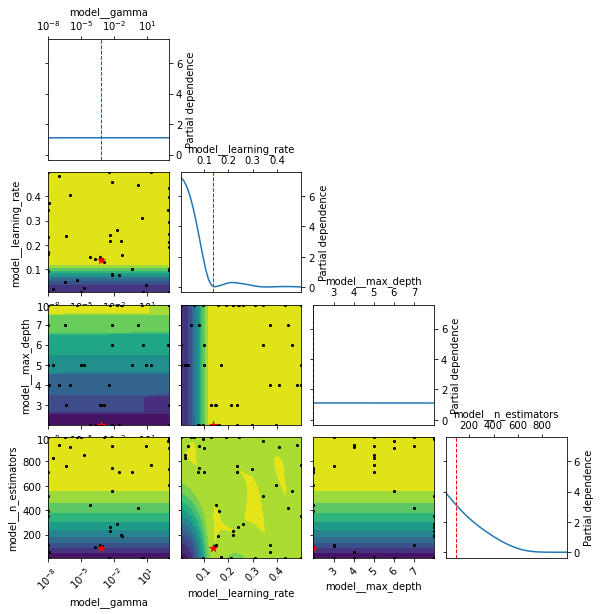

In [11]:
_ = plot_objective(opt.optimizer_results_[0])
plt.show()

### Evaluation Plot

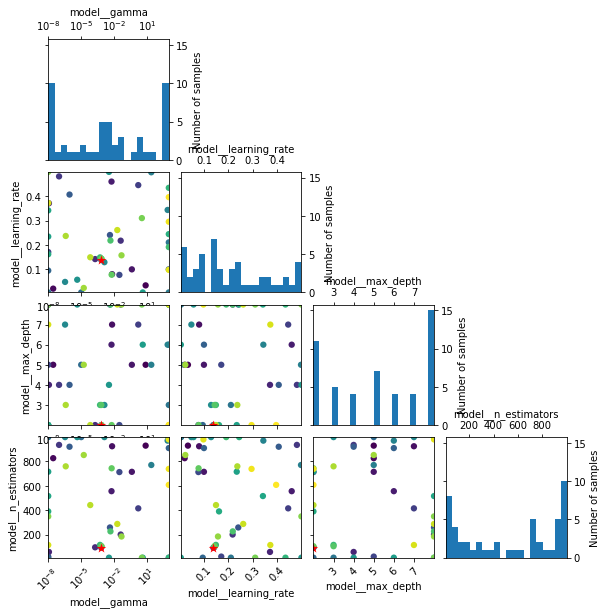

In [12]:
_ = plot_evaluations(opt.optimizer_results_[0])
plt.show()

## Expected Improvement
These plots are fit with different values of $\xi$ to favor exploration vs. exploitation.
### Exploration

In [13]:
my_cb = partial(cb,filename='../Output/tuning_results_EI.csv',verbose = 1)
opt = BayesSearchCV(
    pipe,
    search_grid,
    fit_params = fit_params,
    n_iter=10,
    cv=3,
    return_train_score = True,
    optimizer_kwargs = {'acq_func':'EI','random_state' : 55,'acq_optimizer_kwargs' : {'xi': 0.3}}
)

opt.fit(X_train,y_train,callback = my_cb)

[Pipeline] ............. (step 1 of 1) Processing model, total=   8.3s
[Pipeline] ............. (step 1 of 1) Processing model, total=  10.1s
[Pipeline] ............. (step 1 of 1) Processing model, total=   8.0s
Tried OrderedDict([('model__gamma', 1.0766139223893914e-08), ('model__learning_rate', 0.258450832341508), ('model__max_depth', 3), ('model__n_estimators', 930), ('model__objective', 'count:poisson')]), score =-0.00695552764679438
best score = -0.00695552764679438 @ diff = 0.00224630630856878
[Pipeline] ............. (step 1 of 1) Processing model, total=   7.5s
[Pipeline] ............. (step 1 of 1) Processing model, total=   7.4s
[Pipeline] ............. (step 1 of 1) Processing model, total=   7.3s
Tried OrderedDict([('model__gamma', 3.369560897958231e-08), ('model__learning_rate', 0.30853825979994687), ('model__max_depth', 5), ('model__n_estimators', 539), ('model__objective', 'count:poisson')]), score =-0.007532972107875947
best score = -0.00695552764679438 @ diff = 0.0022

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                      

Best Iteration: 9   BestScore: -0.0018455753004013196
Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0.00011689748969983738,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.27485517009650995,
                              max_delta_step=0.699999988, max_depth=7,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=26,
                              n_jobs=36, num_parallel_tree=1,
                              objective='count:poisson', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                              subsample=1, tree_method='exact',
                              

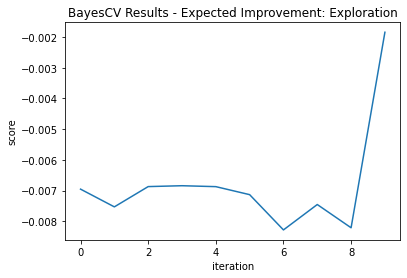

In [14]:
print("Best Iteration:",opt.best_index_,"  BestScore:" ,opt.best_score_)
print(opt.best_estimator_)
rslts = pd.DataFrame.from_dict(opt.cv_results_)
plt.plot(rslts.index,rslts['mean_test_score'])
plt.title('BayesCV Results - Expected Improvement: Exploration')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

### Exploitation

In [15]:
my_cb = partial(cb,filename='../Output/tuning_results_EI_exploit.csv',verbose = 1)
opt = BayesSearchCV(
    pipe,
    search_grid,
    fit_params = fit_params,
    n_iter=10,
    cv=3,
    return_train_score = True,
    optimizer_kwargs = {'acq_func':'EI','random_state' : 55,'acq_optimizer_kwargs' :{'xi':0.01}}
)

opt.fit(X_train,y_train,callback = my_cb)

[Pipeline] ............. (step 1 of 1) Processing model, total=   5.8s
[Pipeline] ............. (step 1 of 1) Processing model, total=   6.8s
[Pipeline] ............. (step 1 of 1) Processing model, total=   8.2s
Tried OrderedDict([('model__gamma', 0.437000966577137), ('model__learning_rate', 0.3856864643131005), ('model__max_depth', 3), ('model__n_estimators', 593), ('model__objective', 'count:poisson')]), score =-0.006824882904346384
best score = -0.006824882904346384 @ diff = 0.0005143153343313599
[Pipeline] ............. (step 1 of 1) Processing model, total=   2.6s
[Pipeline] ............. (step 1 of 1) Processing model, total=   2.7s
[Pipeline] ............. (step 1 of 1) Processing model, total=   2.6s
Tried OrderedDict([('model__gamma', 0.5223454701724685), ('model__learning_rate', 0.32740765357983753), ('model__max_depth', 7), ('model__n_estimators', 76), ('model__objective', 'count:poisson')]), score =-0.006920694224704702
best score = -0.006824882904346384 @ diff = 0.0005143

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                      

Best Iteration: 0   BestScore: -0.006824882904346384
Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0.437000966577137,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.3856864643131005,
                              max_delta_step=0.699999988, max_depth=3,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=593,
                              n_jobs=36, num_parallel_tree=1,
                              objective='count:poisson', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                              subsample=1, tree_method='exact',
                              valida

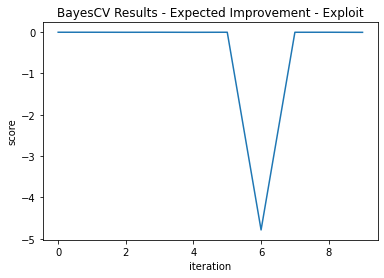

In [16]:
print("Best Iteration:",opt.best_index_,"  BestScore:" ,opt.best_score_)
print(opt.best_estimator_)
rslts = pd.DataFrame.from_dict(opt.cv_results_)
plt.plot(rslts.index,rslts['mean_test_score'])
plt.title('BayesCV Results - Expected Improvement - Exploit')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Probability of Improvement
These plots are fit with different values of $\xi$ to favor exploration vs. exploitation.
### Exploration

In [17]:
my_cb = partial(cb,filename='../Output/tuning_results_PI.csv',verbose = 1)
opt = BayesSearchCV(
    pipe,
    search_grid,
    fit_params = fit_params,
    n_iter=10,
    cv=3,
    return_train_score = True,
    optimizer_kwargs = {'acq_func':'PI','random_state' : 55,'acq_optimizer_kwargs' :{'xi':0.5}}
)

opt.fit(X_train,y_train,callback = my_cb)

[Pipeline] ............. (step 1 of 1) Processing model, total=   2.5s
[Pipeline] ............. (step 1 of 1) Processing model, total=   2.6s
[Pipeline] ............. (step 1 of 1) Processing model, total=   2.6s
Tried OrderedDict([('model__gamma', 4.258617080673965e-06), ('model__learning_rate', 0.1952582697721836), ('model__max_depth', 4), ('model__n_estimators', 241), ('model__objective', 'count:poisson')]), score =-0.006832318722008888
best score = -0.006832318722008888 @ diff = 0.001212559490857936
[Pipeline] ............. (step 1 of 1) Processing model, total=  11.7s
[Pipeline] ............. (step 1 of 1) Processing model, total=  12.9s
[Pipeline] ............. (step 1 of 1) Processing model, total=  11.5s
Tried OrderedDict([('model__gamma', 4.4953401404491), ('model__learning_rate', 0.45818053244112333), ('model__max_depth', 7), ('model__n_estimators', 622), ('model__objective', 'count:poisson')]), score =-0.007114933142174088
best score = -0.006832318722008888 @ diff = 0.001212

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                      

Best Iteration: 0   BestScore: -0.006832318722008888
Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=4.258617080673965e-06,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.1952582697721836,
                              max_delta_step=0.699999988, max_depth=4,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=241,
                              n_jobs=36, num_parallel_tree=1,
                              objective='count:poisson', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                              subsample=1, tree_method='exact',
                              va

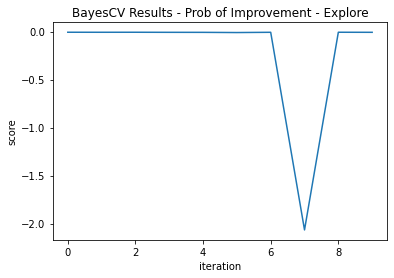

In [18]:
print("Best Iteration:",opt.best_index_,"  BestScore:" ,opt.best_score_)
print(opt.best_estimator_)
rslts = pd.DataFrame.from_dict(opt.cv_results_)
plt.plot(rslts.index,rslts['mean_test_score'])
plt.title('BayesCV Results - Prob of Improvement - Explore')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

### Exploitation

In [19]:
my_cb = partial(cb,filename='../Output/tuning_results_PI_exploit.csv',verbose = 1)
opt = BayesSearchCV(
    pipe,
    search_grid,
    fit_params = fit_params,
    n_iter=10,
    cv=3,
    return_train_score = True,
    optimizer_kwargs = {'acq_func':'PI','random_state' : 55,'acq_optimizer_kwargs' :{'xi':0.05}}
)

opt.fit(X_train,y_train,callback = my_cb)

[Pipeline] ............. (step 1 of 1) Processing model, total=   7.0s
[Pipeline] ............. (step 1 of 1) Processing model, total=   6.9s
[Pipeline] ............. (step 1 of 1) Processing model, total=   7.0s
Tried OrderedDict([('model__gamma', 0.03250009909049239), ('model__learning_rate', 0.055935787793021566), ('model__max_depth', 6), ('model__n_estimators', 544), ('model__objective', 'count:poisson')]), score =-0.006901433997118166
best score = -0.006901433997118166 @ diff = 0.002533773552721133
[Pipeline] ............. (step 1 of 1) Processing model, total=  10.6s
[Pipeline] ............. (step 1 of 1) Processing model, total=  10.7s
[Pipeline] ............. (step 1 of 1) Processing model, total=  10.7s
Tried OrderedDict([('model__gamma', 4.6989871984538874e-08), ('model__learning_rate', 0.33147449457270517), ('model__max_depth', 6), ('model__n_estimators', 818), ('model__objective', 'count:poisson')]), score =-0.009308217993741777
best score = -0.006901433997118166 @ diff = 0

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                      

Best Iteration: 6   BestScore: -0.006847144207057635
Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=1.877529795300085e-07,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.052188765729290286,
                              max_delta_step=0.699999988, max_depth=6,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=437,
                              n_jobs=36, num_parallel_tree=1,
                              objective='count:poisson', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                              subsample=1, tree_method='exact',
                              

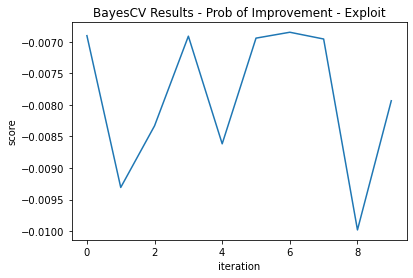

In [20]:
print("Best Iteration:",opt.best_index_,"  BestScore:" ,opt.best_score_)
print(opt.best_estimator_)
rslts = pd.DataFrame.from_dict(opt.cv_results_)
plt.plot(rslts.index,rslts['mean_test_score'])
plt.title('BayesCV Results - Prob of Improvement - Exploit')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Lower Confidence Bound
These plots are fit with different values of $\kappa$ to favor exploration vs. exploitation.
### Exploration

In [21]:
my_cb = partial(cb,filename='../Output/tuning_results_LCB.csv',verbose = 1)
opt = BayesSearchCV(
    pipe,
    search_grid,
    fit_params = fit_params,
    n_iter=10,
    cv=3,
    return_train_score = True,
    optimizer_kwargs = {'acq_func':'LCB','random_state' : 55,'acq_optimizer_kwargs' :{'kappa': 2.3263}}
)

opt.fit(X_train,y_train,callback = my_cb)

[Pipeline] ............. (step 1 of 1) Processing model, total=   5.8s
[Pipeline] ............. (step 1 of 1) Processing model, total=   5.9s
[Pipeline] ............. (step 1 of 1) Processing model, total=   6.5s
Tried OrderedDict([('model__gamma', 503.8665759236637), ('model__learning_rate', 0.14821378825602435), ('model__max_depth', 8), ('model__n_estimators', 308), ('model__objective', 'count:poisson')]), score =-0.008289684474760728
best score = -0.008289684474760728 @ diff = 7.887120897359656e-09
[Pipeline] ............. (step 1 of 1) Processing model, total=   5.0s
[Pipeline] ............. (step 1 of 1) Processing model, total=   4.9s
[Pipeline] ............. (step 1 of 1) Processing model, total=   4.8s
Tried OrderedDict([('model__gamma', 23.41019337698924), ('model__learning_rate', 0.13923464828801416), ('model__max_depth', 3), ('model__n_estimators', 687), ('model__objective', 'count:poisson')]), score =-0.007564598588217198
best score = -0.007564598588217198 @ diff = 3.638335

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                      

Best Iteration: 2   BestScore: -0.003085569224509967
Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0.026849235974420127,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.054173942225780466,
                              max_delta_step=0.699999988, max_depth=7,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=129,
                              n_jobs=36, num_parallel_tree=1,
                              objective='count:poisson', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                              subsample=1, tree_method='exact',
                              v

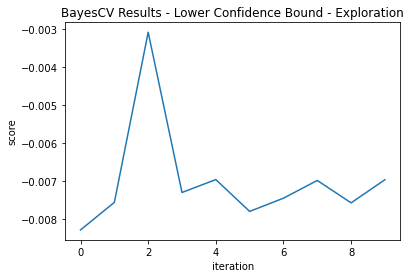

In [22]:
print("Best Iteration:",opt.best_index_,"  BestScore:" ,opt.best_score_)
print(opt.best_estimator_)
rslts = pd.DataFrame.from_dict(opt.cv_results_)
plt.plot(rslts.index,rslts['mean_test_score'])
plt.title('BayesCV Results - Lower Confidence Bound - Exploration')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

### Exploitation

In [23]:
my_cb = partial(cb,filename='../Output/tuning_results_LCB_exploit.csv',verbose = 1)
opt = BayesSearchCV(
    pipe,
    search_grid,
    fit_params = fit_params,
    n_iter=10,
    cv=3,
    return_train_score = True,
    optimizer_kwargs = {'acq_func':'LCB','random_state' : 55,'acq_optimizer_kwargs' :{'kappa': 1.38}}
)

opt.fit(X_train,y_train,callback = my_cb)

[Pipeline] ............. (step 1 of 1) Processing model, total=   1.0s
[Pipeline] ............. (step 1 of 1) Processing model, total=   1.0s
[Pipeline] ............. (step 1 of 1) Processing model, total=   1.0s
Tried OrderedDict([('model__gamma', 0.004238627756068399), ('model__learning_rate', 0.012166503434749149), ('model__max_depth', 3), ('model__n_estimators', 144), ('model__objective', 'count:poisson')]), score =-3.6124768377964207
best score = -3.6124768377964207 @ diff = 0.00018363276479060886
[Pipeline] ............. (step 1 of 1) Processing model, total=   1.4s
[Pipeline] ............. (step 1 of 1) Processing model, total=   1.3s
[Pipeline] ............. (step 1 of 1) Processing model, total=   1.3s
Tried OrderedDict([('model__gamma', 1.7877788932834263e-08), ('model__learning_rate', 0.20432368386647362), ('model__max_depth', 3), ('model__n_estimators', 181), ('model__objective', 'count:poisson')]), score =-0.006851008781087601
best score = -0.006851008781087601 @ diff = 0.

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                      

Best Iteration: 6   BestScore: -0.0012636698838352184
Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=9.531815880973612e-07,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.1188473352003102,
                              max_delta_step=0.699999988, max_depth=5,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=79,
                              n_jobs=36, num_parallel_tree=1,
                              objective='count:poisson', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                              subsample=1, tree_method='exact',
                              va

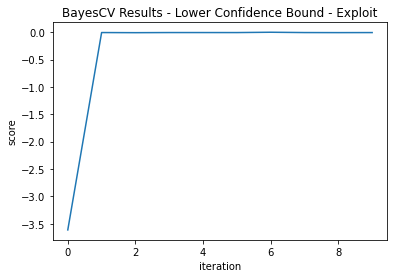

In [24]:
print("Best Iteration:",opt.best_index_,"  BestScore:" ,opt.best_score_)
print(opt.best_estimator_)
rslts = pd.DataFrame.from_dict(opt.cv_results_)
plt.plot(rslts.index,rslts['mean_test_score'])
plt.title('BayesCV Results - Lower Confidence Bound - Exploit')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()